# Random Walk
Calculation of end-to-end distance, radius of gyration, end monomer distribution

Radius of gyration: 
$R_g^2 = \frac{1}{N} \sum_i (\vec{r}_i - \vec{r}_{com})^2$

End to end position distribution 1D:
$P_{1D}(N,x) = \frac{1}{\sqrt{(2 \pi N b^2 )}} e^{-\frac{x^2}{2Nb^2}}$

End to end position distribution radial:
$P_{1D}(N,R) 4\pi R^2 dR = 4 \pi \left( \frac{3}{(2 \pi N b^2 )} \right)^{3/2}  e^{-\frac{3 R^2}{2Nb^2}} R^2 dR$

Load environments

In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from scipy.optimize import curve_fit

In [36]:
class randomWalker:
    ''' class of the random walk
    containing random path construction, Monte Carlo moves and calculation functions for
    end-to-end vector/distance, radius of gyration and a sanity check for valid conformations
    '''
    def __init__(self, N_):
        ''' init function of class random walk setting:
        N - number of steps
        empty start position, end position, and empty full path 
        the definition of allowed steps '''
        self.N = N_
        self.start = np.zeros((2))
        self.currentPos = np.zeros((2))
        self.fullPath   = np.zeros((2))
        self.end = np.zeros((2))
        # self.steps = [(0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1), (-1,0), (-1,1)]
        self.steps = [(0,1), (1,0), (0,-1), (-1,0)]
        
    def createRandomPath(self):
        ''' create an initial random path '''
        # always start at the start position defined in init
        self.currentPos = np.copy(self.start)
        self.fullPath   = np.zeros((2))
        
        # perform the walk
        sizeOfStep = len(self.steps)
        for i in range(self.N-1):
            newStep = self.steps[np.random.randint(sizeOfStep)]
            self.currentPos += newStep
            self.fullPath = np.vstack( (self.fullPath, self.currentPos) )
            
        # store last position in self.end
        self.end = self.currentPos
        
    def plotThePath(self):
        ''' plot the current full path using plt.scatter(...) '''
        figure()
        scatter(self.fullPath[:,0], self.fullPath[:,1], c='olive',alpha=0.9,s=4)
        plot(self.fullPath[:,0], self.fullPath[:,1], "-", c='green', alpha=0.5,lw=0.5, label = "full path")
        plot(self.start[0], self.start[1],"r+", label = "start")
        plot(self.end[0], self.end[1],"bo", label = "end")
        legend(loc="best")
        show()
            
    def getEndToEndDistanceVector(self):
        ''' return the end to end vector '''
        return (self.end - self.start)
    
    def getEndToEndDistance(self):
        ''' return the norm of the end to end vector '''
        return np.linalg.norm(self.getEndToEndDistanceVector())
    
    def getRadiusOfGyrationSquared(self):
        ''' calculate the radius of gyration '''
        if self.fullPath.size == 2:
            raise NameError("Rg cannot be calculated from a single point")
            
        #centerOfMass = ( np.sum(self.fullPath[:,0]) / self.fullPath.shape[0] , np.sum(self.fullPath[:,1]) / self.fullPath.shape[0] )
        centerOfMass = self.fullPath.sum(axis=0) / self.fullPath.shape[0]
        
        #rgVector = np.sum( np.square( self.fullPath - centerOfMass ) / self.fullPath.shape[0], axis = 0 )
        #return np.sum(rgVector)
        return  np.sum( np.square( self.fullPath - centerOfMass ) / self.fullPath.shape[0] )
    
    def performMCS(self, times):
        ''' run the importance sampling times-times '''
        sizeOfStep = len(self.steps)
        # run this t times
        for t in range(times):
            
            # run this N times
            for n in range(self.N):
                # randomly choose a lattice site
                randomSite = np.random.randint(0,self.N)
                
                # check if it is the first point
                if (randomSite == 0):
                    # calculate difference to neigbor
                    diff = self.fullPath[1]-self.fullPath[0]
                    # get new position and avoid double lattice occupation
                    newStep = self.steps[np.random.randint(sizeOfStep)]
                    while ( (newStep[0] == -diff[0]) and (newStep[1] == -diff[1]) ):
                        newStep = self.steps[np.random.randint(sizeOfStep)]
                    # update position
                    self.fullPath[0]+=(newStep+diff)
                    # update start 
                    self.start = 1*self.fullPath[0]

                # check if it is the last point
                elif(randomSite == (self.N-1)):
                    # calculate difference to neigbor
                    diff = self.fullPath[-2]-self.fullPath[-1]
                    # get new position and avoid double lattice occupation
                    newStep = self.steps[np.random.randint(sizeOfStep)]
                    while ( (newStep[0] == -diff[0]) and (newStep[1] == -diff[1]) ):
                        newStep = self.steps[np.random.randint(sizeOfStep)]
                    # update position
                    self.fullPath[-1]+=(newStep+diff)
                    # update end
                    self.end = 1*self.fullPath[-1]
                    
                # ... or something in between
                else:
                    diff1 = self.fullPath[randomSite+1]-self.fullPath[randomSite]
                    diff2 = self.fullPath[randomSite-1]-self.fullPath[randomSite]
                    if not ( ( diff1[0] == -diff2[0] ) and ( diff1[1] == -diff2[1] ) ):
                        '''
                        if not +-+-+ bond a move along the diffs is possible:
                        with a kink:
                        1-2     1
                          |  -> |
                          3     2-3
                        or a return
                        13-2 -> 2-13
                        yielding valid moves
                        ''' 
                        self.fullPath[randomSite] += (diff1+diff2)
                    
            # sanity check (bond lengths and path length)
            if not self.checkConfig():
                return False
        return True
    
    def checkConfig(self):
        '''
        Sanity check function to check for correct bond length and path lenght.
        It returns true in case everything is allright and false if an error occured.
        '''
        for i, n in enumerate(self.fullPath):
            if i < (self.N-1):
                if ( np.abs((n-self.fullPath[i+1])[0]+(n-self.fullPath[i+1])[1]) != 1 ):
                    return False
        if (self.N != len(self.fullPath) ):
            return False
        return True
            
# other functions to be used in this project:
''' definition of 1D Gaussian '''
def gaussian1D(x,R2):
    return 1/np.sqrt(2*np.pi*R2) * np.exp( -(x*x)/(2*R2) )

def radialGaussian(x,R2):
    ''' definition of radial Gaussian '''
    return 4*np.pi * (3/(2*np.pi*R2))**(3/2) * np.exp( - (3*x*x)/(2*R2))*x*x

at the beginning:  16 [(0, 1), (1, 0), (0, -1), (-1, 0)] [0. 0.] [0. 0.] [0. 0.]

make the path

after path creation:
 (16, 2) 32 

5.25


<IPython.core.display.Javascript object>


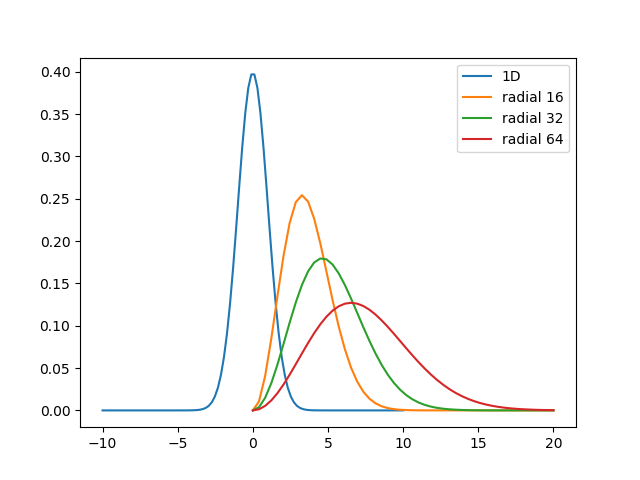

 init function of class random walk setting:
        N - number of steps
        empty start position, end position, and empty full path 
        the definition of allowed steps 
 run the importance sampling times-times 


In [27]:
hugo = randomWalker(16)
print("at the beginning: ", hugo.N, hugo.steps, hugo.currentPos, hugo.end, hugo.start)

print("\nmake the path\n")
hugo.createRandomPath()

print("after path creation:\n",hugo.fullPath.shape,hugo.fullPath.size,"\n")
print(hugo.getRadiusOfGyrationSquared())

figure()
x = np.linspace(-10,10,100)
plot(x,gaussian1D(x,1), label = "1D")
x = np.linspace(0,20,50)
plot(x,radialGaussian(x,16), label="radial 16")
plot(x,radialGaussian(x,32), label="radial 32")
plot(x,radialGaussian(x,64), label="radial 64")
legend(loc="best")
show()

# check the docs
print(hugo.__init__.__doc__)
print(hugo.performMCS.__doc__)

## Simple Sampling

In [30]:
# run the simple sampling simulations
endPositionsX = []
endPositionsR = []
endToEndPosSq = []
radiusGyratSq = []

walkLength = 512 # 512
n_iter = 1000 #  1000

walker = randomWalker(walkLength)

for i in range(n_iter):
    # create a sample
    walker.createRandomPath()
    
    # make a measurement
    endToEndPosSq.append( walker.getEndToEndDistance()**2 )
    radiusGyratSq.append( walker.getRadiusOfGyrationSquared() )
    endPositionsX.append( walker.getEndToEndDistanceVector()[0] )
    endPositionsR.append( walker.getEndToEndDistance() )

end to end: R^2 = 529.30, R = 23.01
gyration r: R^2 = 87.95, R = 9.38


<IPython.core.display.Javascript object>


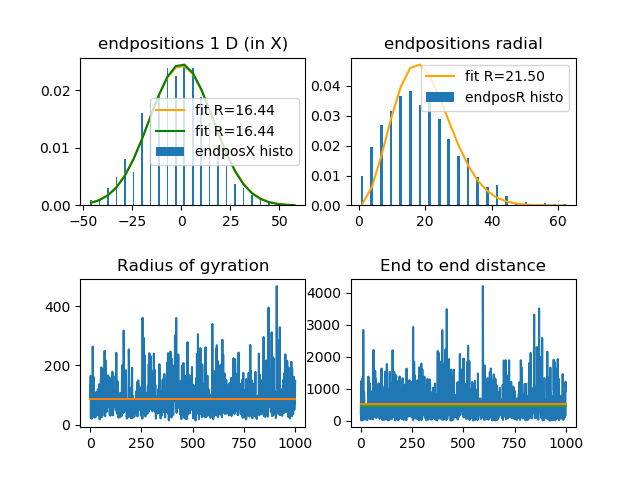

2 * Ree1D^2 == Ree^2 ?:
2 * 16.44^2 = 540.30 == 529.30


In [39]:
# calculate averages
Rg2 = sum(radiusGyratSq)/len(radiusGyratSq)
Re2 = sum(endToEndPosSq)/len(endToEndPosSq)
print("end to end: R^2 = {0:.2f}, R = {1:.2f}".format(Re2,np.sqrt(Re2)))
print("gyration r: R^2 = {0:.2f}, R = {1:.2f}".format(Rg2,np.sqrt(Rg2)))

# make histograms
endPosXHisto, endPosXBins = np.histogram(endPositionsX, bins="auto", density = True)
endPosRHisto, endPosRBins = np.histogram(endPositionsR, bins="auto", density = True)

figure()
subplot(221)
x = endPosXBins[0:-1]
y = endPosXHisto
bar(x,y, label="endposX histo")
fit_params, covar = curve_fit( gaussian1D, x, y, p0=(Re2/2) )
plot(x,gaussian1D(x, *fit_params), label="fit R={0:.2f}".format(np.sqrt(fit_params[0])), c = "orange")
#plot(x,gaussian1D(x, 529.30/2), label="fit R={0:.2f}".format(np.sqrt(fit_params[0])), c = "green")
# hist(endPositionsX, bins="auto", label="plt.hist", rwidth=0.5)
# store squared 1D end-to-end dist
fitRee2 = fit_params[0]
legend()
title("endpositions 1 D (in X)")

subplot(222)
x = endPosRBins[0:-1]
y = endPosRHisto
bar(x,y, label="endposR histo")
fit_params, covar = curve_fit(radialGaussian, x, y)
plot(x,radialGaussian(x, *fit_params), label="fit R={0:.2f}".format(np.sqrt(fit_params[0])), c = "orange")
# hist(endPositionsR, bins="auto", label="plt.hist", rwidth=0.5)
legend()
title("endpositions radial")

subplot(223)
plot(np.linspace(0,len(radiusGyratSq),len(radiusGyratSq)),radiusGyratSq)
plot([0,len(radiusGyratSq)],[Rg2,Rg2])
title("Radius of gyration")

subplot(224)
plot(np.linspace(0,len(endToEndPosSq),len(endToEndPosSq)),endToEndPosSq)
plot([0,len(endToEndPosSq)],[Re2,Re2])
plot([0,len(endToEndPosSq)],[fit_params[0],fit_params[0]])
title("End to end distance")

subplots_adjust(hspace=.5)

show()

print( "2 * Ree1D^2 == Ree^2 ?:\n2 * {0:.2f}^2 = {1:.2f} == {2:.2f}".format(np.sqrt(fitRee2), 2*fitRee2, Re2 ))

#ax2.bar(endPosDistBins[0:(len(endPosDistHisto))],endPosDistHisto, color='r')
#ax3.bar(endPosDistinXBins[0:(len(endPosDistinXHisto))],endPosDistinXHisto, color ='b')


In [7]:
''' make a function from the above simulation code '''
def performSimpleSample(N,n_iter):
    walker = randomWalker(N)
    endToEndPosSq = []
    radiusGyratSq = []

    for i in range(n_iter):
        # create a sample
        walker.createRandomPath()
    
        # make a measurement
        endToEndPosSq.append( walker.getEndToEndDistance()**2 )
        radiusGyratSq.append( walker.getRadiusOfGyrationSquared() )
    
    Rg2 = sum(radiusGyratSq)/len(radiusGyratSq)
    Re2 = sum(endToEndPosSq)/len(endToEndPosSq)
    
    return Re2, Rg2

''' define power law '''
def powerLaw(x,a,b):
    return a*x**b

In [8]:
# ## run the Re(N) simulations
walkLengths = [16,32,64,128,256,512,1024,2048]
n_iter = 1000
Re = []
Rg = []

for myN in walkLengths:
    re2, rg2 = performSimpleSample(myN,n_iter)
    print(re2,rg2)
    Re.append(re2)
    Rg.append(rg2)    

13.784 2.49634375
32.216 5.42649609375
64.064 10.48780615234375
129.604 21.680548950195313
245.476 41.6700358581543
510.504 84.20963442230224
1067.708 173.48516657066347
2039.412 339.2029318165779


<IPython.core.display.Javascript object>


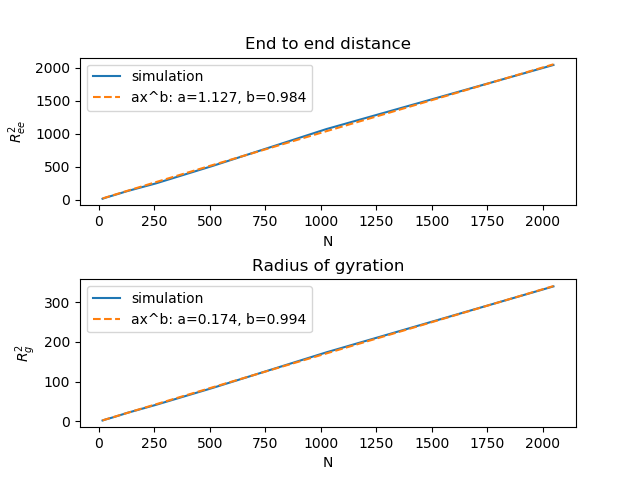

b1/b2 = 6.5 ( = 6 ?)


In [9]:
figure()
subplot(211)
plot(walkLengths,Re, label="simulation")
fit_params, covar = curve_fit(powerLaw, walkLengths, Re)
plot(walkLengths,powerLaw(walkLengths,*fit_params), "--", label="ax^b: a={0:.3f}, b={1:.3f}".format(*fit_params))
title("End to end distance")
xlabel("N")
ylabel(r"$R_{ee}^2$")
legend()
b1 = np.copy(fit_params[0])

subplot(212)
plot(walkLengths,Rg, label="simulation")
fit_params, covar = curve_fit(powerLaw, walkLengths, Rg)
plot(walkLengths,powerLaw(walkLengths,*fit_params), "--", label="ax^b: a={0:.3f}, b={1:.3f}".format(*fit_params))
title("Radius of gyration")
xlabel("N")
ylabel(r"$R_{g}^2$")
legend()

subplots_adjust(hspace=.5)

print( "b1/b2 = {0:.2} ( = 6 ?)".format(b1/fit_params[0]) )

## Importance sampling
autocorrelation function:

$c(\Delta t) = \frac{\langle R_e(t_0) * Re(t_0 + \Delta t)\rangle}{\langle Re^2 \rangle}$

In [10]:
# run a long simulation with perform mcs function

n_iter = 10000
n_step = 1
N = 64

# empty result container
Re = []

# setup walker
impWalker = randomWalker(N)
impWalker.createRandomPath()

# run the simulations
for i in range(n_iter):
    impWalker.performMCS(n_step)
    Re.append( impWalker.getEndToEndDistanceVector() )

In [11]:
# get averaged re
Re2 = 0
for r in Re:
    Re2 +=np.dot(r,r)
Re2 /= len(Re)
print(Re2)

# run the autocorrelation
numSamples = int(floor(n_iter/n_step))
redt = []
for dt in range(numSamples):
    redt.append(np.dot(Re[0],Re[dt]))
    
print(redt[0],redt[-1])

48.1092
117.0 -60.0


In [48]:
def sampleReDt(n_iter,N):
    # setup walker
    impWalker = randomWalker(N)
    impWalker.createRandomPath()
    
    # initial result container
    firstRe = impWalker.getEndToEndDistanceVector()
    ReDt = [np.dot(firstRe,firstRe)]
    Re2 = [np.square(impWalker.getEndToEndDistance())]
    
    # run the simulations
    for i in range(n_iter-1):
        impWalker.performMCS(1)
        Re2.append(np.square(impWalker.getEndToEndDistance()))
        ReDt.append(np.dot(firstRe,impWalker.getEndToEndDistanceVector()))
        
    # average the Re2
    reMean = sum(Re2)/len(Re2)
    # return the results
    return reMean, np.array(ReDt)

In [53]:
# run the ReDt sampling many times
s_time = 10000
n_sample = 100
N = 64

meanReDt = np.zeros(s_time)
reMean = 0.0

for n in range(n_sample):
    reC, redtC = sampleReDt(s_time, N)
    print(reC, redtC.size)
    reMean += reC
    meanReDt += redtC

reMean /= n_sample
meanReDt /= n_sample
print(reMean, meanReDt[:4])

73.2252 10000
46.5236 10000
59.5076 10000
48.6136 10000
63.6436 10000
70.356 10000
74.1352 10000
83.7968 10000
64.1184 10000
66.8604 10000
55.358 10000
59.0892 10000
55.8784 10000
79.2584 10000
71.406 10000
51.5948 10000
72.2048 10000
64.4532 10000
62.1972 10000
44.9236 10000
54.8536 10000
57.9256 10000
71.2096 10000
71.2392 10000
53.15 10000
66.3652 10000
60.5132 10000
63.3912 10000
55.6588 10000
69.7928 10000
66.164 10000
59.6316 10000
60.92 10000
55.8868 10000
49.438 10000
65.5944 10000
89.556 10000
62.3564 10000
66.7128 10000
53.4588 10000
58.9336 10000
42.2456 10000
68.6756 10000
63.1684 10000
55.9364 10000
78.2188 10000
54.0008 10000
69.1624 10000
52.8004 10000
44.7284 10000
78.1088 10000
68.3976 10000
71.352 10000
57.19 10000
67.776 10000
51.68 10000
57.026 10000
51.6232 10000
41.444 10000
72.1604 10000
71.9612 10000
64.8224 10000
46.6332 10000
64.0084 10000
65.184 10000
55.2428 10000
70.3416 10000
71.0776 10000
62.7324 10000
51.4628 10000
66.4856 10000
63.6216 10000
65.162 1000

<IPython.core.display.Javascript object>


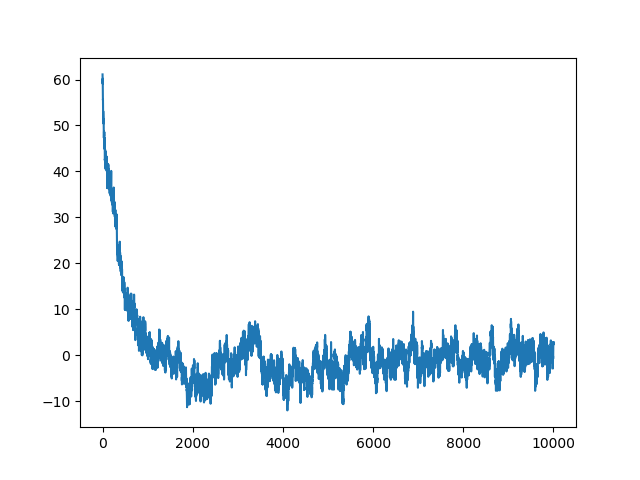

In [54]:
figure()
plot(np.linspace(0,s_time,s_time),meanReDt)
show()